Program that takes in an hdf5 file with 3d array of simulation and outputs the radial profile. Then attempts to fit it onto the analytic radial profile.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from scipy.optimize import minimize

Function takes in path for hdf5 file and outputs a 3d array with all the densities:

In [10]:
# function takes in a path and outputs a 3d array of the density profile.

def file_to_density(path_name):
    hf = h5py.File(path_name, 'r')
    psi_real = np.array(hf['psiRe'])
    psi_im = np.array(hf['psiIm'])
    psi_real2 = psi_real**2
    psi_im2 = psi_im**2
    rho = (psi_real2 + psi_im2)
    return rho

Function rolls the density array so that the core is in the center of the image.

In [11]:
#function takes in a cubic np density array and rolls it so tha the highest point is in the center.
#only to be used for the steady state images

def rho_roll(rho):
    rho_len = rho.shape[0]
    # finding the maximum value's index
    max_ind = np.where(rho == np.amax(rho))
    x_max = max_ind[0][0]
    y_max = max_ind[1][0]
    z_max = max_ind[2][0]
    signed_x_dist_to_cent = int(rho_len / 2) - x_max
    signed_y_dist_to_cent = int(rho_len / 2) - y_max
    signed_z_dist_to_cent = int(rho_len / 2) - z_max
    #moving the core to the center of the cube
    rho_n = np.roll(rho, signed_x_dist_to_cent, axis=0)
    rho_n2 = np.roll(rho_n, signed_y_dist_to_cent, axis=1)
    rho_n3 = np.roll(rho_n2, signed_z_dist_to_cent, axis=2)
    rho = rho_n3
    return rho

A helper function that computes the distance between two 3d points.

In [12]:
# function that calculates distances between two 3d points:

def get_distance(a, b):
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2]- b[2])**2)

Function returns a dictionary with the radii as keys and a list of the densities as values.

In [13]:
#function that takes in a 3d array with highest point at the center and calculates
#the density as a function of radius fromt the center of the core. returns as a dictionary with
#distances as keys and a list of the densities as the value.

def radial_density(rho):
    rho_len = rho.shape[0]
    center = int(rho_len / 2)
    radii_den = {}
    for i in range(0, rho_len):
        for j in range(0, rho_len):
            for k in range(0, rho_len):
                dist = get_distance([center, center, center], [i, j, k])
                dens = rho[i][j][k]
                if dist not in radii_den:
                    radii_den[dist] = [dens]
                else:
                    radii_den[dist].append(dens)
    return radii_den

# testing
a = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
b = np.array([[[1, 4], [3, 4]], [[5, 6], [7, 8]]])
dict = radial_density(a)
print(len(dict))
dist = np.fromiter(dict.keys(), dtype=float)
print(dist)


4
[1.73205081 1.41421356 1.         0.        ]


This function takes in a dictionary of radii and densities and returns two numpy arrays, one with radii and the other with average densities.

In [6]:
#function that plots radial density. Takes in a dictionary with densities as keys
# and the densities as values and outputs two np arrays, one with the distances 
# and one with the ---average--- density at that radial distance.

def rad_avg_den(dict, scale_factor):
    dict_len = len(dict)
    dist = np.fromiter(dict.keys(), dtype=float)
    avgs = np.zeros(dict_len)
    for x in range(0, dict_len):
        dens = np.array(dict[dist[x]])
        avg = np.mean(dens)
        avgs[x] = avg
    return dist * scale_factor, avgs
# testing
#res = rad_avg_den(dict)
#print(res[0])
#print(res[1])

Function returns two numpy arrays, one with the radial positions, and the other with all the densities, even the ones with the doubled up radial positions.

In [7]:
# function that takes in dictionary and prints two np arrays, one with the points
# and another with the corresponding densities, including doubles.

def rad_den(dict):
    dict_len = len(dict)
    dist_list = np.fromiter(dict.keys(), dtype=float)
    dist = []
    dens = []
    for x in range(0, dict_len):
        curr_dist = dist_list[x]
        list_len = len(dict[dist_list[x]])
        for i in range(0, list_len):
            dist.append(curr_dist)
            dens.append(dict[dist_list[x]][i])
    dist = np.asarray(dist)
    dens = np.asarray(dens)
    return dist * (20/128), dens

In [8]:
# from path to distance and average density arrays
def file_to_rad_avg_den(path):
    rho = file_to_density(path)
    rho = rho_roll(rho)
    scale_factor = 20 / rho.shape[0]
    rad_den = radial_density(rho)
    return rad_avg_den(rad_den, scale_factor)

In [9]:
# from path to distance and unaveraged density arrays
def file_to_rad_den(path):
    rho = file_to_density(path)
    rho = rho_roll(rho)
    radial_den = radial_density(rho)
    return rad_den(radial_den)

Testing all the functions to see if they work:

In [ ]:
#testing the file to density function
path = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/fInfL20T4n400r128/snap0300.h5'
res = file_to_rad_avg_den(path)
res2 = file_to_rad_den(path)

In [ ]:
print(len(res[0]))
print(10e4)

In [ ]:
fig_path = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/fInfL20T4n400r128'
fig_name = 'pic300'
plt.scatter(res[0], res[1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density')
plt.ylim(10**4, 10**(10.5))
plt.xlim(10**(-0.5), 10**(2.2))
plt.savefig(fig_path + "/" + fig_name)
plt.clf()

In [ ]:
#file to picture
def file_to_pic(path_to_dir, fig_num, f_str):
    res = file_to_rad_avg_den(path_to_dir + '/snap' + fig_num  + '.h5')
    plt.scatter(res[0], res[1])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radial Distance (kpc)')
    plt.ylabel('Density (Msun / (kpc)^3)')
    plt.title('Radial Distance vs. Density: f = ' + f_str)
    plt.ylim(10**4, 10**(10.5))
    plt.xlim(10**(-1), 10**(2.2))
    plt.savefig(path_to_dir + "/" + f_str + 'pic' + fig_num)
    plt.clf()

In [ ]:
#testing
file_to_pic('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/fInfL20T4n400r128', '0350', 'Inf')
file_to_pic('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f1L20T4n400r128', '0350', '1')
file_to_pic('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f2L20T4n400r128', '0350', '2')
file_to_pic('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f4L20T4n400r128', '0350', '4')


Function fitting

In [ ]:
test_path = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f1L20T4n400r128/snap0350.h5'
sample_data = file_to_rad_avg_den(test_path)
print(sample_data[0])

In [ ]:
#cuts off a distance array such that it only has elements < a certain length

def dist_cutoff(dist, dist_lim):
    distance = []
    for x in dist:
        if (x < dist_lim):
            distance.append(x)
    return np.asarray(distance)

In [ ]:
#cuts off a density array at a given number of elements
#not in place

def dens_cutoff(dens, n_elements):
    densities = np.zeros(n_elements)
    for i in range(0, n_elements):
        densities[i] = dens[i]
    return densities

In [14]:
#analytic profile of the core

def an_prof(r, rc):
    rho = ((1.9*10**7) / (rc**4)) #*((1/0.1)**2)
    term = (1 + 0.091*(r/rc)**2)**-8
    return rho * term

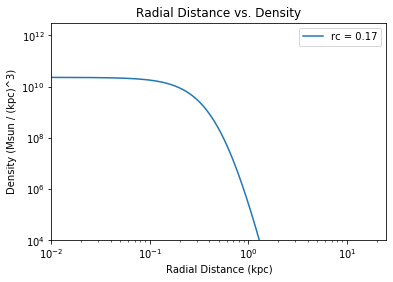

In [21]:
x = np.linspace(0.00001, 20, 100000)
#y16 = an_prof(x, 0.16)
y17 = an_prof(x, 0.17)
#y18 = an_prof(x, 0.18)
#plt.plot(x, y16)
plt.plot(x, y17)
#plt.plot(x, y18)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density')
plt.ylim(10**4, 10**(12.5))
plt.xlim(10**(-2), 10**(1.4))
plt.legend(['rc = 0.17'])

In [ ]:
#X2 function

def X2_fun(rc, dist, dens, dist_lim):
    r = dist_cutoff(dist, dist_lim)
    densities = dens_cutoff(dens, len(r))
    X2 = (((an_prof(r, rc)) - densities)**2)
    indices = [0, len(X2)-1]
    return X2[indices].sum()

In [ ]:
#radial-density fitting function
#params are two nparrays
#analytic radial profile function

def fit_profile(dist, dens, dist_lim):
    dist1 = np.sort(dist)
    dens1 = (-1)*(np.sort(dens*(-1)))
    params = (dist1, dens1, dist_lim)
    x0 = np.asarray(3)
    result = minimize(X2_fun, x0, args = params)
    return result

test_result = fit_profile(sample_data[0], sample_data[1], 10**(-1.1))
print(test_result)

#testing
rc = test_result.x[0]
dist_lim = 0.65
r = sample_data[0]
densities = sample_data[1]
plt.scatter(r, densities)
plt.plot(r, an_prof(r, rc))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density')
plt.ylim(10**4, 10**(12.5))
plt.xlim(10**(-2), 10**(1.4))
textstr = 'rc = ' + "%.2f" % rc
plt.legend(['Analytic Profile, rc = ' + "%.2f" % rc,'Simulation'])
plt.show()

In [ ]:
def file_to_pic_curve_fit(path, file, dist_lim):
    arrs = file_to_rad_avg_den(path + '/' + file)
    dist = arrs[0]
    dens = arrs[1]
    dist1 = np.sort(dist)
    dens1 = (-1)*(np.sort(dens*(-1)))
    res = fit_profile(dist1, dens1, dist_lim)
    rc = res.x[0]
    plt.scatter(dist1, dens1)
    plt.plot(dist1, an_prof(dist1, rc))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radial Distance (kpc)')
    plt.ylabel('Density (Msun / (kpc)^3)')
    plt.title('Radial Distance vs. Density')
    plt.ylim(10**4, 10**(12.5))
    plt.xlim(10**(-2), 10**(1.4))
    textstr = 'rc = ' + "%.2f" % rc
    plt.legend(['Analytic Profile, rc = ' + "%.2f" % rc,'Simulation'])
    plt.savefig(path + '/pic' + file + '.png')
    

In [ ]:
file_to_pic_curve_fit('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f1L20T4n400r128', 'snap0350.h5', .1)

In [ ]:
file_to_pic_curve_fit('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/fInfL20T4n400r128', 'snap0350.h5', .65)

In [ ]:
file_to_pic_curve_fit('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f2L20T4n400r128', 'snap0350.h5', 0.65)

In [ ]:
file_to_pic_curve_fit('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f4L20T4n400r128', 'snap0350.h5', 0.65)

In [ ]:
file_to_pic_curve_fit('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/output/f1.5L20T4n400r128', 'snap0350.h5', 0.65)

In [ ]:
# trying to write the radial profile to hdf5 file along with minimized rc parameter
def path_to_radial_h5(path_to_folder, snap_number):
    result = file_to_rad_avg_den(path_to_folder + '/snap' + str(snap_number).zfill(4) + '.h5')
    dist = np.sort(result[0])
    dens = (-1)*(np.sort(result[1]*(-1)))
    dist_lim = 0.65
    params = (dist, dens, dist_lim)
    x0 = np.asarray(2)
    res = minimize(X2_fun, x0, args = params)
    rc = res.x[0]
    
    hf = h5py.File(path_to_folder + '/' + 'radial' + str(snap_number) + '.h5', 'w')
    hf.create_dataset('distances', data=dist)
    hf.create_dataset('densities', data=dens)
    hf.create_dataset('rc', data=rc)
    hf.close()

In [ ]:
# writes radial h5 files for all files in folder:
def radial_h5_folder(path, n_snap):
    dir = path + '/rad_files'
    if not os.path.exists(dir):
        os.mkdir(dir)
    for i in range(0, n_snap + 1):
        result = file_to_rad_avg_den(path + '/snap' + str(i).zfill(4) + '.h5')
        dist = np.sort(result[0])
        dens = (-1)*(np.sort(result[1]*(-1)))
        dist_lim = 0.65
        params = (dist, dens, dist_lim)
        x0 = np.asarray(2)
        res = minimize(X2_fun, x0, args = params)
        rc = res.x[0]
        # saving as file
        hf = h5py.File(dir + '/' + 'radial' + str(i).zfill(4) + '.h5', 'w')
        hf.create_dataset('distances', data=dist)
        hf.create_dataset('densities', data=dens)
        hf.create_dataset('rc', data=rc)
        hf.close()
        
#testing
folder = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n40r64'
radial_h5_folder(folder, 40)

In [ ]:
path_to_radial_h5('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1875L20T4n40r64', 40)

In [ ]:
#analyzing data for f = 1.1875
path = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1875L20T4n40r256'

for i in range(0, 41):    
    hf = h5py.File(path + '/radial' + str(i).zfill(4) + '.h5', 'r')
    dist = np.array(hf['distances'])
    dens = np.array(hf['densities'])
    plt.scatter(dist, dens)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radial Distance (kpc)')
    plt.ylabel('Density (Msun / (kpc)^3)')
    plt.title('Radial Distance vs. Density')
    plt.ylim(10**4, 10**(12.5))
    plt.xlim(10**(-2), 10**(1.4))
    plt.savefig(path + '/pics/pic' + str(i).zfill(4) + '.png')
    plt.clf()


Trying to plot enclosed mass as a function of radius in the case of the analytic profile (assuming a spherical object)

In [ ]:
def enclosed_mass(r, dens):
    V = (4/3)*np.pi*r**3
    return V*dens

In [ ]:
r = np.linspace(0, 15, 1000000)

dens = an_prof(r, 0.18)
m = enclosed_mass(r,dens)
m = m*15/1000000
sum = 0
menc = np.zeros(1000000)
for i in range(1, 1000000):
    menc[i] = sum
    sum = sum + m[i]
plt.plot(r, menc)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('M(enclosed) (Msun)')
plt.title('Enclosed Mass vs. Distance')
plt.ylim(10**(5), 10**(11))
plt.xlim(10**(-3), 10**(1))



In [ ]:
#plotting radial profiles of different densities

#naming file paths
path64 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r64/radial0400.h5'
path128 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r128/radial0400.h5'
path256 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r256/radial0400.h5'
path400 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r400/radial0400.h5'

#opening files and assigning to arrays
hf64 = h5py.File(path64, 'r')
hf128 = h5py.File(path128, 'r')
hf256 = h5py.File(path256, 'r')
hf400 = h5py.File(path400, 'r')

dist64 = np.array(hf64['distances'])
dens64 = np.array(hf64['densities'])
dist128 = np.array(hf128['distances'])
dens128 = np.array(hf128['densities'])
dist256 = np.array(hf256['distances'])
dens256 = np.array(hf256['densities'])
dist400 = np.array(hf400['distances'])
dens400 = np.array(hf400['densities'])

plt.plot(dist64, dens64)
plt.plot(dist128, dens128)
plt.plot(dist256, dens256)
plt.plot(dist400, dens400)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density')
plt.ylim(10**4, 10**(12.5))
plt.xlim(10**(-2), 10**(1.4))

plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun/ kpc^3)')
plt.title('Radius vs. Density')
plt.legend(['r = 64', 'r = 128', 'r = 256', 'r = 400'])

plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/smooth_convergence_testf2.png')

In [ ]:
#plotting radial profiles of different densities

#naming file paths
path64 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r64/radial0400.h5'
path128 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r128/radial0400.h5'
path256 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r256/radial0400.h5'
path400 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r400/radial0400.h5'

#opening files and assigning to arrays
hf64 = h5py.File(path64, 'r')
hf128 = h5py.File(path128, 'r')
hf256 = h5py.File(path256, 'r')
hf400 = h5py.File(path400, 'r')

dist64 = np.array(hf64['distances'])
dens64 = np.array(hf64['densities'])
dist128 = np.array(hf128['distances'])
dens128 = np.array(hf128['densities'])
dist256 = np.array(hf256['distances'])
dens256 = np.array(hf256['densities'])
dist400 = np.array(hf400['distances'])
dens400 = np.array(hf400['densities'])

plt.scatter(dist64, dens64, s = 0.25)
plt.scatter(dist128, dens128, s = 0.25)
plt.scatter(dist256, dens256, s = 0.25)
plt.scatter(dist400, dens400, s = 0.25)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density')
plt.ylim(10**4, 10**(12.5))
plt.xlim(10**(-2), 10**(1.4))

plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun/ kpc^3)')
plt.title('Radius vs. Density')
plt.legend(['r = 64', 'r = 128', 'r = 256', 'r = 400'])


plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/scatter_convergence_testf2.png')

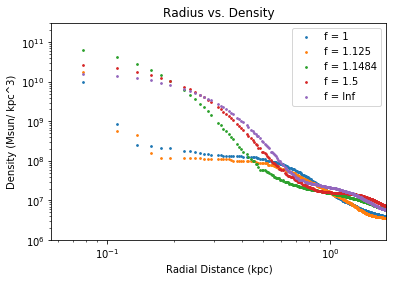

In [7]:
#plotting radial profiles of different densities

#naming file paths
path1 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n400r256/radial0400.h5'
#path10625 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.0625L20T4n40r256/radial0040.h5'
path1125 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.125L20T4n40r256/radial0040.h5'
#path11406 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1406L20T4n40r256/radial0040.h5'
path11484 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1484L20T4n40r256/radial0040.h5'
path11562 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1562L20T4n40r256/radial0040.h5'
path11875 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1875L20T4n40r256/radial0040.h5'
path125 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.25L20T4n40r256/radial0040.h5'
path15 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.5L20T4n400r256/radial0400.h5'
path175 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.75L20T4n40r256/radial0040.h5'
path2 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r256/radial0400.h5'
path4 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f4L20T4n400r256/radial0400.h5'
pathInf ='/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n400r256/rad_filesradial0400.h5'

#opening files and assigning to arrays
hf1 = h5py.File(path1, 'r')
#hf10625 = h5py.File(path10625, 'r')
hf1125 = h5py.File(path1125, 'r')
#hf11406 = h5py.File(path11406, 'r')
hf11484 = h5py.File(path11484, 'r')
hf11562 = h5py.File(path11562, 'r')
hf11875 = h5py.File(path11875, 'r')
hf125 = h5py.File(path125, 'r')
hf15 = h5py.File(path15, 'r')
hf175 = h5py.File(path175, 'r')
hf2 = h5py.File(path2, 'r')
hf4 = h5py.File(path4, 'r')
hfInf = h5py.File(pathInf, 'r')

dist1 = np.array(hf1['distances'])
dens1 = np.array(hf1['densities'])

#dist10625 = np.array(hf10625['distances'])
#dens10625 = np.array(hf10625['densities'])

dist1125 = np.array(hf1125['distances'])
dens1125 = np.array(hf1125['densities'])

#dist11406 = np.array(hf11406['distances'])
#dens11406 = np.array(hf11406['densities'])

dist11484 = np.array(hf11484['distances'])
dens11484 = np.array(hf11484['densities'])

dist11562 = np.array(hf11562['distances'])
dens11562 = np.array(hf11562['densities'])

dist11875 = np.array(hf11875['distances'])
dens11875 = np.array(hf11875['densities'])

dist125 = np.array(hf125['distances'])
dens125 = np.array(hf125['densities'])

dist15 = np.array(hf15['distances'])
dens15 = np.array(hf15['densities'])

dist175 = np.array(hf175['distances'])
dens175 = np.array(hf175['densities'])

dist2 = np.array(hf2['distances'])
dens2 = np.array(hf2['densities'])

dist4 = np.array(hf4['distances'])
dens4 = np.array(hf4['densities'])

distInf = np.array(hfInf['distances'])
densInf = np.array(hfInf['densities'])

plt.scatter(dist1, dens1, s = 3)
#plt.scatter(dist10625, dens10625, s = 0.25)
plt.scatter(dist1125, dens1125, s = 3)
#plt.scatter(dist11406, dens11406, s = 0.25)
plt.scatter(dist11484, dens11484, s = 3)
#plt.scatter(dist11562, dens11562, s = 3)
#plt.scatter(dist11875, dens11875, s = 3)
#plt.scatter(dist125, dens125, s = 3)
plt.scatter(dist15, dens15, s = 3)
#plt.scatter(dist175, dens175, s = 3)
#plt.scatter(dist2, dens2, s = 3)
#plt.scatter(dist4, dens4, s = 3)
plt.scatter(distInf, densInf, s = 3)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density')
plt.ylim(10**6, 10**(11.5))
plt.xlim(10**(-1.25), 10**(0.25))

plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun/ kpc^3)')
plt.title('Radius vs. Density')
plt.legend(['f = 1', 'f = 1.125', 'f = 1.1484', 'f = 1.5', 'f = Inf'])

plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f_r256_uncollapsed.png', dpi = 200)

In [ ]:
def getcusp(num):
    return 

In [28]:
# Testing the cuspiness as a function of f for uncollapsed cases
path11484 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1484L20T4n40r256/radial0040.h5'
path11562 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1562L20T4n40r256/radial0040.h5'
path11875 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1875L20T4n40r256/radial0040.h5'
path125 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.25L20T4n40r256/radial0040.h5'
path15 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.5L20T4n400r256/radial0400.h5'
path175 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.75L20T4n40r256/radial0040.h5'
path2 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r256/radial0400.h5'
path4 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f4L20T4n400r256/radial0400.h5'
pathInf ='/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n400r256/rad_filesradial0400.h5'

#opening files and assigning to arrays
hf11484 = h5py.File(path11484, 'r')
hf11562 = h5py.File(path11562, 'r')
hf11875 = h5py.File(path11875, 'r')
hf125 = h5py.File(path125, 'r')
hf15 = h5py.File(path15, 'r')
hf175 = h5py.File(path175, 'r')
hf2 = h5py.File(path2, 'r')
hf4 = h5py.File(path4, 'r')
hfInf = h5py.File(pathInf, 'r')

dist11484 = np.array(hf11484['distances'])
dens11484 = np.array(hf11484['densities'])

dist11562 = np.array(hf11562['distances'])
dens11562 = np.array(hf11562['densities'])

dist11875 = np.array(hf11875['distances'])
dens11875 = np.array(hf11875['densities'])

dist125 = np.array(hf125['distances'])
dens125 = np.array(hf125['densities'])

dist15 = np.array(hf15['distances'])
dens15 = np.array(hf15['densities'])

dist175 = np.array(hf175['distances'])
dens175 = np.array(hf175['densities'])

dist2 = np.array(hf2['distances'])
dens2 = np.array(hf2['densities'])

dist4 = np.array(hf4['distances'])
dens4 = np.array(hf4['densities'])

distInf = np.array(hfInf['distances'])
densInf = np.array(hfInf['densities'])

cen_denInf = densInf[0]
cen_den4 = dens4[0]
cen_den2 = dens2[0]
cen_den175 = dens175[0]
cen_den125 = dens125[0]
cen_den11875 = dens11875[0]
cen_den11562 = dens11562[0]
cen_den11484 = dens11484[0]

cuspInf = np.abs((np.log10(densInf[1]) - np.log10(densInf[2]))/(np.log10(distInf[1]) - np.log10(distInf[2]))) 
cusp4 = np.abs((np.log10(dens4[1]) - np.log10(dens4[2]))/(np.log10(dist4[1]) - np.log10(dist4[2])))
cusp2 = np.abs((np.log10(dens2[1]) - np.log10(dens2[2]))/(np.log10(dist2[1]) - np.log10(dist2[2])))
cusp175 = np.abs((np.log10(dens175[1]) - np.log10(dens175[2]))/(np.log10(dist175[1]) - np.log10(dist175[2])))
cusp125 = np.abs((np.log10(dens125[1]) - np.log10(dens125[2]))/(np.log10(dist125[1]) - np.log10(dist125[2])))
cusp11875 = np.abs((np.log10(dens11875[1]) - np.log10(dens11875[2]))/(np.log10(dist11875[1]) - np.log10(dist11875[2])))
cusp11562 = np.abs((np.log10(dens11562[1]) - np.log10(dens11562[2]))/(np.log10(dist11562[1]) - np.log10(dist11562[2])))
cusp11484 = np.abs((np.log10(dens11484[1]) - np.log10(dens11484[2]))/(np.log10(dist11484[1]) - np.log10(dist11484[2])))


cen_dens = [cen_denInf, cen_den4, cen_den2, cen_den175, cen_den125, cen_den11875, cen_den11562, cen_den11484]
cusps = [cuspInf, cusp4, cusp2, cusp175, cusp125, cusp11875, cusp11562, cusp11484]
strengths = [0, 0.25, 0.5, 1/1.75, 1/1.25, 1/1.11875, 1/1.1562, 1/1.1484]

plt.scatter(strengths, cusps)
plt.xlabel('1/f')
plt.ylabel('Slope between 2nd and 3rd point')
plt.title('Interaction Strength vs. Cuspiness')
plt.savefig('/mnt/c/Users/Noah Notis/Desktop/cuspiness.png', dpi = 200)
plt.clf()

plt.scatter(strengths, cen_dens)
plt.yscale('log')
plt.xlabel('1/f')
plt.ylabel('Central Density (Msun/kpc^3)')
plt.title('Interaction Strength vs. Central Density')
plt.savefig('/mnt/c/Users/Noah Notis/Desktop/cen_dens.png', dpi = 200)
plt.clf()

<Figure size 432x288 with 0 Axes>

In [ ]:
#plotting radial profiles of different densities

#naming file paths
path1 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n400r400/radial0200.h5'
#path125 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.25L20T4n40r400/radial0040.h5'
path15 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.5L20T4n400r400/radial0200.h5'
#path175 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.75L20T4n40r400/radial0040.h5'
path2 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r400/radial0400.h5'
path4 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f4L20T4n400r400/radial0400.h5'
pathInf ='/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n400r400/radial0400.h5'

#opening files and assigning to arrays
hf1 = h5py.File(path1, 'r')
#hf125 = h5py.File(path125, 'r')
hf15 = h5py.File(path15, 'r')
#hf175 = h5py.File(path175, 'r')
hf2 = h5py.File(path2, 'r')
hf4 = h5py.File(path4, 'r')
hfInf = h5py.File(pathInf, 'r')

dist1 = np.array(hf1['distances'])
dens1 = np.array(hf1['densities'])

#dist125 = np.array(hf125['distances'])
#dens125 = np.array(hf125['densities'])

dist15 = np.array(hf15['distances'])
dens15 = np.array(hf15['densities'])

#dist175 = np.array(hf175['distances'])
#dens175 = np.array(hf175['densities'])

dist2 = np.array(hf2['distances'])
dens2 = np.array(hf2['densities'])

dist4 = np.array(hf4['distances'])
dens4 = np.array(hf4['densities'])

distInf = np.array(hfInf['distances'])
densInf = np.array(hfInf['densities'])

plt.scatter(dist1, dens1, s = 0.25)
#plt.scatter(dist125, dens125, s = 0.25)
plt.scatter(dist15, dens15, s = 0.25)
#plt.scatter(dist175, dens175, s = 0.25)
plt.scatter(dist2, dens2, s = 0.25)
plt.scatter(dist4, dens4, s = 0.25)
plt.scatter(distInf, densInf, s = 0.25)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density')
plt.ylim(10**4, 10**(12.5))
plt.xlim(10**(-2), 10**(1.4))

plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun/ kpc^3)')
plt.title('Radius vs. Density')
plt.legend(['f = 1', 'f = 1.5', 'f = 2', 'f = 4', 'f = Inf'])

plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f_r400.png', dpi = 200)

Check here:

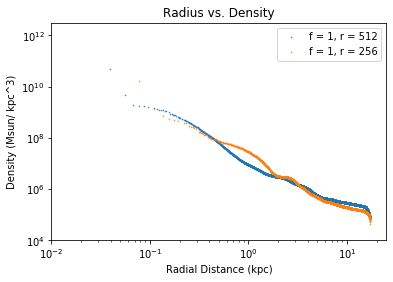

In [3]:
#Looking at the f1r512 case
path1 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n40r512/radial0018.h5'
path1256 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n400r256/radial0180.h5'

hf1 = h5py.File(path1, 'r')
hf1256 = h5py.File(path1256, 'r')

dist1 = np.array(hf1['distances'])
dens1 = np.array(hf1['densities'])

dist1256 = np.array(hf1256['distances'])
dens1256 = np.array(hf1256['densities'])

plt.scatter(dist1, dens1, s = 0.25)
plt.scatter(dist1256, dens1256, s = 0.25)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density')
plt.ylim(10**4, 10**(12.5))
plt.xlim(10**(-2), 10**(1.4))

plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun/ kpc^3)')
plt.title('Radius vs. Density')
plt.legend(['f = 1, r = 512', 'f = 1, r = 256'])
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1r512snap18.png', dpi = 200)

In [ ]:
#plotting radial profiles of different densities

#naming file paths
path64 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r64/radial0400.h5'
path128 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r128/radial0400.h5'
path256 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r256/radial0400.h5'
path400 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r400/radial0400.h5'

#opening files and assigning to arrays
hf64 = h5py.File(path64, 'r')
hf128 = h5py.File(path128, 'r')
hf256 = h5py.File(path256, 'r')
hf400 = h5py.File(path400, 'r')

dist64 = np.array(hf64['distances'])
dens64 = np.array(hf64['densities'])
dist128 = np.array(hf128['distances'])
dens128 = np.array(hf128['densities'])
dist256 = np.array(hf256['distances'])
dens256 = np.array(hf256['densities'])
dist400 = np.array(hf400['distances'])
dens400 = np.array(hf400['densities'])

#plt.scatter(dist64, dens64)
#plt.scatter(dist128, dens128)
#plt.scatter(dist256, dens256)
#plt.scatter(dist400, dens400)


#plt.xlabel('Radial Distance (kpc)')
#plt.ylabel('Density (Msun/ kpc^3)')
#plt.title('Radius vs. Density')
#plt.legend(['r = 64', 'r = 128', 'r = 256', 'r = 400'])


fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(dist64, dens64)
axs[0, 0].set_title('R = 64')
axs[0, 0].loglog()
axs[0, 0].set_ylim(10**4, 10**(12.5))
axs[0, 0].set_xlim(10**(-2), 10**(1.4))
#axs[0, 0].xlabel('Radial Distance (kpc)')
#axs[0, 0].ylabel('Density (Msun / (kpc)^3)')
#axs[0, 0].title('Radial Distance vs. Density')


axs[0, 1].scatter(dist128, dens128)
axs[0, 1].set_title('R = 128')
axs[0, 1].loglog()
axs[0, 1].set_ylim(10**4, 10**(12.5))
axs[0, 1].set_xlim(10**(-2), 10**(1.4))

axs[1, 0].scatter(dist256, dens256)
axs[1, 0].set_title('R = 256')
axs[1, 0].loglog()
axs[1, 0].set_ylim(10**4, 10**(12.5))
axs[1, 0].set_xlim(10**(-2), 10**(1.4))

axs[1, 1].scatter(dist400, dens400)
axs[1, 1].set_title('R = 400')
axs[1, 1].loglog()
axs[1, 1].set_ylim(10**4, 10**(12.5))
axs[1, 1].set_xlim(10**(-2), 10**(1.4))

#fig.suptitle('Density Profiles', fontsize=16, pad = 20)
for ax in axs.flat:
    ax.set(xlabel='Radius (kpc)', ylabel='Density (Msun/kpc^3)')
plt.tight_layout()
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/convergence_test.png')

In [ ]:
#plotting radial profiles of different densities

#naming file paths

path1 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n400r256/radial0400.h5'
path15 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.5L20T4n400r256/radial0400.h5'
path2 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f2L20T4n400r256/radial0400.h5'
path4 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f4L20T4n400r256/radial0400.h5'

#opening files and assigning to arrays
hf15 = h5py.File(path15, 'r')
hf1 = h5py.File(path1, 'r')
hf2 = h5py.File(path2, 'r')
hf4 = h5py.File(path4, 'r')

dist15 = np.array(hf15['distances'])
dens15 = np.array(hf15['densities'])
dist1 = np.array(hf1['distances'])
dens1 = np.array(hf1['densities'])
dist2 = np.array(hf2['distances'])
dens2 = np.array(hf2['densities'])
dist4 = np.array(hf4['distances'])
dens4 = np.array(hf4['densities'])

#plt.scatter(dist64, dens64)
#plt.scatter(dist128, dens128)
#plt.scatter(dist256, dens256)
#plt.scatter(dist400, dens400)


#plt.xlabel('Radial Distance (kpc)')
#plt.ylabel('Density (Msun/ kpc^3)')
#plt.title('Radius vs. Density')
#plt.legend(['r = 64', 'r = 128', 'r = 256', 'r = 400'])


fig, axs = plt.subplots(2, 2)
axs[0, 1].scatter(dist15, dens15)
axs[0, 1].set_title('f = 1.5')
axs[0, 1].loglog()
axs[0, 1].set_ylim(10**4, 10**(12.5))
axs[0, 1].set_xlim(10**(-2), 10**(1.4))
#axs[0, 0].xlabel('Radial Distance (kpc)')
#axs[0, 0].ylabel('Density (Msun / (kpc)^3)')
#axs[0, 0].title('Radial Distance vs. Density')


axs[0, 0].scatter(dist1, dens1)
axs[0, 0].set_title('f = 1')
axs[0, 0].loglog()
axs[0, 0].set_ylim(10**4, 10**(12.5))
axs[0, 0].set_xlim(10**(-2), 10**(1.4))

axs[1, 0].scatter(dist2, dens2)
axs[1, 0].set_title('f = 2')
axs[1, 0].loglog()
axs[1, 0].set_ylim(10**4, 10**(12.5))
axs[1, 0].set_xlim(10**(-2), 10**(1.4))

axs[1, 1].scatter(dist4, dens4)
axs[1, 1].set_title('f = 4')
axs[1, 1].loglog()
axs[1, 1].set_ylim(10**4, 10**(12.5))
axs[1, 1].set_xlim(10**(-2), 10**(1.4))

#fig.suptitle('Density Profiles', fontsize=16, pad = 20)
for ax in axs.flat:
    ax.set(xlabel='Radius (kpc)', ylabel='Density (Msun/kpc^3)')
plt.tight_layout()
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/radial_comparison_r256.png')

In [7]:
#takes in a folder and returns an array of its max density as a function of time.
def max_rad(folder_path, snap_num, number):
    max_den = np.zeros(snap_num + 1)
    if (folder_path == '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n400r256'):    
        if (number == 40):
            for i in range(0, snap_num + 1):
                hf = h5py.File(folder_path + '/rad_filesradial' + str(i).zfill(4) + '.h5', 'r')
                den = np.array(hf['densities'])
                max_den[i] = den[0]
        elif (number == 400):
            for i in range(0, snap_num + 1):
                hf = h5py.File(folder_path + '/rad_filesradial' + str(i * 10).zfill(4) + '.h5', 'r')
                den = np.array(hf['densities'])
                max_den[i] = den[0]
    else:
        if (number == 40):
            for i in range(0, snap_num + 1):
                hf = h5py.File(folder_path + '/radial' + str(i).zfill(4) + '.h5', 'r')
                den = np.array(hf['densities'])
                max_den[i] = den[0]
        elif (number == 400):
            for i in range(0, snap_num + 1):
                hf = h5py.File(folder_path + '/radial' + str(i * 10).zfill(4) + '.h5', 'r')
                den = np.array(hf['densities'])
                max_den[i] = den[0]
    return max_den

In [8]:
def get_cusps(path, snap_num, number):
    central_dens = max_rad(path, snap_num, number)
    cusp_slopes = np.zeros(snap_num + 1)
    if (path == '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n400r256'):    
        if (number == 40):
            for i in range(0, snap_num + 1):
                hf = h5py.File(path + '/rad_filesradial' + str(i).zfill(4) + '.h5', 'r')
                dist = np.array(hf['distances'])
                den = np.array(hf['densities'])
                slope = np.abs((np.log10(den[1]) - np.log10(den[2])) / (np.log10(dist[1]) - np.log10(dist[2])))
                cusp_slopes[i] = slope
        elif (number == 400):
            for i in range(0, snap_num + 1):
                hf = h5py.File(path + '/rad_filesradial' + str(i * 10).zfill(4) + '.h5', 'r')
                dist = np.array(hf['distances'])
                den = np.array(hf['densities'])
                slope = np.abs((np.log10(den[1]) - np.log10(den[2])) / (np.log10(dist[1]) - np.log10(dist[2])))
                cusp_slopes[i] = slope
    else:
        if (number == 40):
            for i in range(0, snap_num + 1):
                hf = h5py.File(path + '/radial' + str(i).zfill(4) + '.h5', 'r')
                dist = np.array(hf['distances'])
                den = np.array(hf['densities'])
                slope = np.abs((np.log10(den[1]) - np.log10(den[2])) / (np.log10(dist[1]) - np.log10(dist[2])))
                cusp_slopes[i] = slope
        elif (number == 400):
            for i in range(0, snap_num + 1):
                hf = h5py.File(path + '/radial' + str(i * 10).zfill(4) + '.h5', 'r')
                dist = np.array(hf['distances'])
                den = np.array(hf['densities'])
                slope = np.abs((np.log10(den[1]) - np.log10(den[2])) / (np.log10(dist[1]) - np.log10(dist[2])))
                cusp_slopes[i] = slope
    return central_dens, cusp_slopes

Testing get cusps

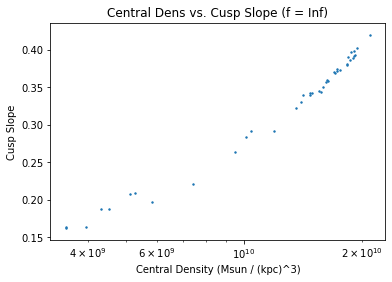

In [54]:
#Testing get cusps

#pathf11562 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1562L20T4n40r256'
#pathf11875 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1875L20T4n40r256'
#pathf125 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.25L20T4n40r256'
#pathf15 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.5L20T4n400r256'
#pathf175 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.75L20T4n40r256'
#pathf4 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f4L20T4n400r256'
pathfInf = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n400r256'

#cusps11562 = get_cusps(pathf11562, 40, 40)
#cusps11875 = get_cusps(pathf11875, 40, 40)
#cusps125 = get_cusps(pathf125, 40, 40)
#cusps15 = get_cusps(pathf15, 40, 400)
#cusps175 = get_cusps(pathf175, 40, 40)
#cusps4 = get_cusps(pathf4, 40, 400)
cuspsInf = get_cusps(pathfInf, 40, 400)

plt.scatter(cuspsInf[0], cuspsInf[1], s = 2)
#plt.scatter(cusps4[0], cusps4[1], s = 2)
#plt.scatter(cusps175[0], cusps175[1], s = 2)
#plt.scatter(cusps15[0], cusps15[1], s = 2)
#plt.scatter(cusps125[0], cusps125[1], s = 2)
#plt.scatter(cusps11875[0], cusps11875[1], s = 2)
#plt.scatter(cusps11562[0], cusps11562[1], s = 2)

plt.xscale('log')
plt.xlabel('Central Density (Msun / (kpc)^3)')
plt.ylabel('Cusp Slope')
plt.title('Central Dens vs. Cusp Slope (f = Inf)')
#plt.legend(['f = Inf', 'f = 4', 'f = 1.75', 'f = 1.5', 'f = 1.25', 'f = 1.1875', 'f = 1.1562'])

plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/density_cuspfInf.png', dpi = 200)

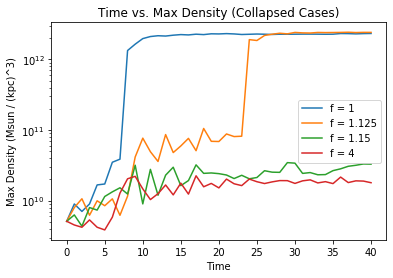

In [18]:
#testing function
pathf1 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n400r256'
#pathf10625 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.0625L20T4n40r256'
pathf1125 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.125L20T4n40r256'
#pathf11406 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1406L20T4n40r256'
path15 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.5L20T4n400r256'
path4 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f4L20T4n400r256'
max_den1 = max_rad(pathf1, 40, 400)
#max_den10625 = max_rad(pathf10625, 40, 40)
max_den1125 = max_rad(pathf1125, 40, 40)
#max_den11406 = max_rad(pathf11406, 40, 40)
max_den15 = max_rad(path15, 40, 400)
max_den4 = max_rad(path4, 40, 400)

time = np.linspace(0,40, 41)

plt.plot(time, max_den1)
#plt.plot(time, max_den10625)
plt.plot(time, max_den1125)
#plt.plot(time, max_den11406)
plt.plot(time, max_den15)
plt.plot(time, max_den4)

plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Max Density (Msun / (kpc)^3)')
plt.title('Time vs. Max Density (Collapsed Cases)')
plt.legend(['f = 1', 'f = 1.125', 'f = 1.15', 'f = 4'])

plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/max_den/some_collapsed_cases_smooth.png', dpi = 200)

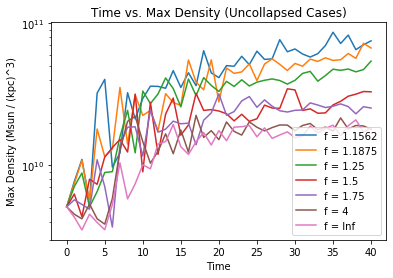

In [31]:
#testing function for uncollapsed Cases
pathf11562 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1562L20T4n40r256'
pathf11875 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1875L20T4n40r256'
pathf125 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.25L20T4n40r256'
pathf15 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.5L20T4n400r256'
pathf175 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.75L20T4n40r256'
pathf4 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f4L20T4n400r256'
pathfInf = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n400r256'

max_den11562 = max_rad(pathf11562, 40, 40)
max_den11875 = max_rad(pathf11875, 40, 40)
max_den125 = max_rad(pathf125, 40, 40)
max_den15 = max_rad(pathf15, 40, 400)
max_den175 = max_rad(pathf175, 40, 40)
max_den4 = max_rad(pathf4, 40, 400)
max_denInf = max_rad(pathfInf, 40, 400)

time = np.linspace(0,40, 41)

plt.plot(time, max_den11562)
plt.plot(time, max_den11875)
plt.plot(time, max_den125)
plt.plot(time, max_den15)
plt.plot(time, max_den175)
plt.plot(time, max_den4)
plt.plot(time, max_denInf)

plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Max Density (Msun / (kpc)^3)')
plt.title('Time vs. Max Density (Uncollapsed Cases)')
plt.legend(['f = 1.1562', 'f = 1.1875', 'f = 1.25', 'f = 1.5', 'f = 1.75', 'f = 4', 'f = Inf'])

plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/max_den/uncollapsed_cases_smooth.png', dpi = 200)

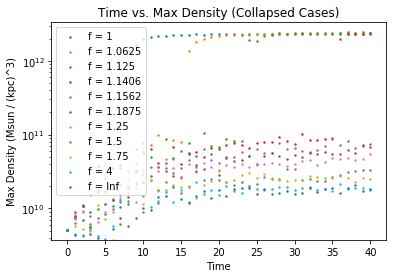

In [32]:
#testing altogether
#testing function
pathf1 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n400r256'
pathf10625 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.0625L20T4n40r256'
pathf1125 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.125L20T4n40r256'
pathf11406 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1406L20T4n40r256'
pathf11562 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1562L20T4n40r256'
pathf11875 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.1875L20T4n40r256'
pathf125 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.25L20T4n40r256'
pathf15 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.5L20T4n400r256'
pathf175 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.75L20T4n40r256'
pathf4 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f4L20T4n400r256'
pathfInf = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n400r256'

max_den1 = max_rad(pathf1, 40, 400)
max_den10625 = max_rad(pathf10625, 40, 40)
max_den1125 = max_rad(pathf1125, 40, 40)
max_den11406 = max_rad(pathf11406, 40, 40)
max_den11562 = max_rad(pathf11562, 40, 40)
max_den11875 = max_rad(pathf11875, 40, 40)
max_den125 = max_rad(pathf125, 40, 40)
max_den15 = max_rad(pathf15, 40, 400)
max_den175 = max_rad(pathf175, 40, 40)
max_den4 = max_rad(pathf4, 40, 400)
max_denInf = max_rad(pathfInf, 40, 400)

time = np.linspace(0,40, 41)

plt.scatter(time, max_den1, s = 2)
plt.scatter(time, max_den10625, s = 2)
plt.scatter(time, max_den1125, s = 2)
plt.scatter(time, max_den11406, s = 2)
plt.scatter(time, max_den11562, s = 2)
plt.scatter(time, max_den11875, s = 2)
plt.scatter(time, max_den125, s = 2)
plt.scatter(time, max_den15, s = 2)
plt.scatter(time, max_den175, s = 2)
plt.scatter(time, max_den4, s = 2)
plt.scatter(time, max_denInf, s = 2)

plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Max Density (Msun / (kpc)^3)')
plt.title('Time vs. Max Density (Collapsed Cases)')
plt.legend(['f = 1', 'f = 1.0625', 'f = 1.125', 'f = 1.1406', 'f = 1.1562', 'f = 1.1875', 'f = 1.25', 'f = 1.5', 'f = 1.75', 'f = 4', 'f = Inf'])

plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/max_den/all_cases_scatter', dpi = 200)

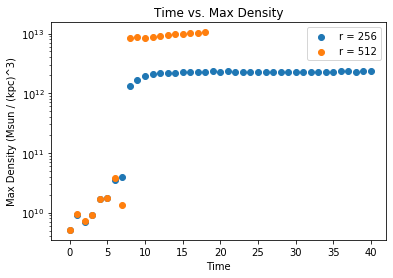

In [13]:
#testing function
pathf1256 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n400r256'
pathf1512 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n40r512'

max_den256 = max_rad(pathf1256, 40, 400)
max_den512 = max_rad(pathf1512, 18, 40)

time256 = np.linspace(0,40, 41)
time512 = np.linspace(0, 18, 19)

plt.scatter(time256, max_den256)
plt.scatter(time512, max_den512)
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Max Density (Msun / (kpc)^3)')
plt.title('Time vs. Max Density')
plt.legend(['r = 256', 'r = 512'])
plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/max_den/res_test_f1.png', dpi = 200)

In [ ]:
#testing function
pathInf = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/fInfL20T4n400r256'
max_den = max_rad(pathInf, 40)
time = np.linspace(0,40, 41)
plt.scatter(time, max_den)
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Max Density (Msun / (kpc)^3)')
plt.title('Time vs. Max Density')

plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/max_den/fInfr256.png', dpi = 200)

In [ ]:
#testing function
path1 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n400r256'
max_den = max_rad(path1, 40)
time = np.linspace(0,40, 41)
plt.scatter(time, max_den)
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Max Density (Msun / (kpc)^3)')
plt.title('Time vs. Max Density')

plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/max_den/f1r256.png', dpi = 200)

In [ ]:
path2 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1.125L20T4n40r256'
max_den = max_rad(path2, 40)
time = np.linspace(0,40, 41)
plt.scatter(time, max_den)
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Max Density (Msun / (kpc)^3)')
plt.title('Time vs. Max Density')

plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/max_den/f1125r256.png', dpi = 200)

In [8]:
def path_to_pic(path, snap_num):
    dir = path + '/pics'
    if not os.path.exists(dir):
        os.mkdir(dir)
    for i in range(0, snap_num + 1):
        hf = h5py.File(path + '/radial' + str(i).zfill(4) + '.h5', 'r')
        dist = np.array(hf['distances'])
        dens = np.array(hf['densities'])
        plt.scatter(dist, dens, s = 0.8)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Radial Distance (kpc)')
        plt.ylabel('Density (Msun / (kpc)^3)')
        plt.title('Radial Distance vs. Density')
        plt.ylim(10**4, 10**(12.5))
        plt.xlim(10**(-2), 10**(1.4))
        plt.savefig(dir + '/pic' + str(i).zfill(4) + '.png', dpi = 200)
        plt.clf()

In [9]:
path1512 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n40r512'
path_to_pic(path1512, 18)

<Figure size 432x288 with 0 Axes>

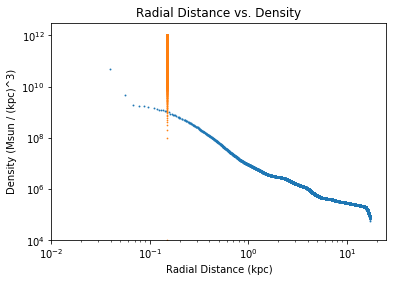

In [31]:
path1512 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n40r512'
path1256 = '/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/rad_files/f1L20T4n400r256'
hf512 = h5py.File(path1512 + '/radial0018.h5', 'r')
dist = np.array(hf['distances'])
dens = np.array(hf['densities'])
plt.scatter(dist, dens, s = 0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance (kpc)')
plt.ylabel('Density (Msun / (kpc)^3)')
plt.title('Radial Distance vs. Density')
plt.ylim(10**4, 10**(12.5))
plt.xlim(10**(-2), 10**(1.4))
y = np.linspace(1e4, 1e12, 10000)
x = np.zeros(10000)
for i in range(0,10000):
    x[i] = 0.15
plt.scatter(x, y, 0.5)

<KeysViewHDF5 ['X2', 'f', 'rc']>
<KeysViewHDF5 ['X2', 'alpha', 'f', 'rc', 'rho']>
<KeysViewHDF5 ['X2', 'exp_inner', 'exp_outer', 'f', 'i1term', 'rc', 'rho']>
[4.39452141e+17 7.33455945e+17 1.95492513e+18 6.76412629e+17
 7.12269194e+18 7.51129514e+19 1.49428149e+20 2.13434028e+20
 4.86166034e+20]
[2.88196136e+17 3.28687734e+17 6.76261471e+17 5.82514664e+17
 8.96153730e+17 2.24019827e+18 2.78402310e+18 3.26501740e+18
 4.84810169e+18]
[9.67800300e+14 4.03258478e+15 1.57257785e+14 2.11935771e+15
 8.91526403e+14 1.96946029e+15 1.29132255e+16 7.91608938e+15
 1.52740194e+16]


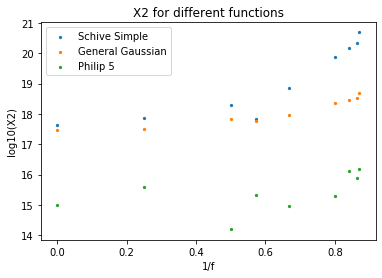

In [39]:
#checking X2 based on different methods
simple = h5py.File('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/simple_function/simple_params.h5', 'r')
gauss = h5py.File('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/gaussian_function/gaussian_params.h5', 'r')
philip = h5py.File('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/philip_function/philip_params.h5', 'r')

print(simple.keys())
print(gauss.keys())
print(philip.keys())

f = 1/np.array(simple['f'])
simple_X2 = np.array(simple['X2'])
gauss_X2 = np.array(gauss['X2'])
philip_X2 = np.array(philip['X2'])

print(simple_X2)
print(gauss_X2)
print(philip_X2)

plt.scatter(f, np.log10(simple_X2), s = 5)
plt.scatter(f, np.log10(gauss_X2), s = 5)
plt.scatter(f, np.log10(philip_X2), s = 5)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('1/f')
plt.ylabel('log10(X2)')
plt.title('X2 for different functions')
plt.legend(['Schive Simple', 'General Gaussian', 'Philip 5'])

plt.savefig('/mnt/c/Users/Noah Notis/Dropbox/USRP2020_Noah/src/FDM2020/pics/function_fitting/X2.png', dpi = 200)